# Finetuning via REINFORCE algorithm

## 1. Import libraries

In [1]:
import os
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [2]:
from coma.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from coma.vae import SmilesAutoencoder, RewardFunction
from coma.properties import drd2, qed, penalized_logp, similarity

/home/descartes/anaconda3/envs/coma/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


## 2. Configure GPU (if available)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Specify a target property

In [4]:
PROPERTY_NAME = "drd2"
SCORING_PROPERTY_FT = drd2
threshold_property = 0.
threshold_similarity = 0.3

#PROPERTY_NAME = "qed"
#SCORING_PROPERTY_FT = qed
#threshold_property = 0.75
#threshold_similarity = 0.3

#PROPERTY_NAME = "logp04"
#SCORING_PROPERTY_FT = penalized_logp
#threshold_property = 0.
#threshold_similarity = 0.3

#PROPERTY_NAME = "logp06"
#SCORING_PROPERTY_FT = penalized_logp
#threshold_property = 0.
#threshold_similarity = 0.5

In [5]:
SCORING_TANIMOTO_FT = similarity

## 4. Describe file information for inputs

In [6]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "data", PROPERTY_NAME))
input_ckpt_dir = f"outputs_1_pretraining_{PROPERTY_NAME}"

In [7]:
filepath_train             = os.path.join(input_data_dir, "rdkit_train_triplet.txt")
filepath_valid             = os.path.join(input_data_dir, "rdkit_valid.txt")
filepath_pretrain_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_pretrain_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_pretrain_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

## 5. Describe file information for outputs

In [8]:
output_dir = f"outputs_2_finetuning_{PROPERTY_NAME}"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [9]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_pretrain_char2idx, device=device)

In [11]:
dataset.save_char2idx(filepath_char2idx)

In [12]:
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Load the pretrained generator of COMA

In [13]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_pretrain_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_pretrain_ckpt)

## Configuration save
generator.save_config(filepath_configs)

## 8. Define a reward function

In [14]:
reward_ft = RewardFunction(similarity_ft=SCORING_TANIMOTO_FT,
                           scoring_ft=SCORING_PROPERTY_FT,
                           threshold_property=threshold_property,
                           threshold_similarity=threshold_similarity)

## 9. Start to train

In [15]:
df_history, df_history_valid = generator.policy_gradient(dataset, reward_ft, validation_dataset=dataset_valid,
                                                         batch_size=1000, total_steps=2000, learning_rate=1e-4,
                                                         discount_factor=0.995, buffer_size=2000, buffer_batch_size=50,
                                                         checkpoint_step=200, checkpoint_filepath=filepath_checkpoint,
                                                         display_step=100, verbose=1)

[000100/002000]  loss: 0.044  reward: 0.392  similarity: 0.536  property: 0.392  valid_ratio(va): 0.996  similarity(va): 0.346  property(va): 0.379  (63.7 min)
[000200/002000]  loss: 0.046  reward: 0.493  similarity: 0.483  property: 0.493  valid_ratio(va): 1.000  similarity(va): 0.331  property(va): 0.474  (132.6 min)
[000300/002000]  loss: 0.046  reward: 0.635  similarity: 0.465  property: 0.635  valid_ratio(va): 1.000  similarity(va): 0.326  property(va): 0.527  (200.9 min)
[000400/002000]  loss: 0.040  reward: 0.539  similarity: 0.464  property: 0.539  valid_ratio(va): 1.000  similarity(va): 0.322  property(va): 0.568  (270.8 min)
[000500/002000]  loss: 0.044  reward: 0.673  similarity: 0.464  property: 0.673  valid_ratio(va): 1.000  similarity(va): 0.321  property(va): 0.595  (339.5 min)
[000600/002000]  loss: 0.049  reward: 0.709  similarity: 0.448  property: 0.709  valid_ratio(va): 1.000  similarity(va): 0.318  property(va): 0.624  (407.6 min)
[000700/002000]  loss: 0.047  rewar

In [16]:
df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

## 10. Visualize for reward & loss analysis

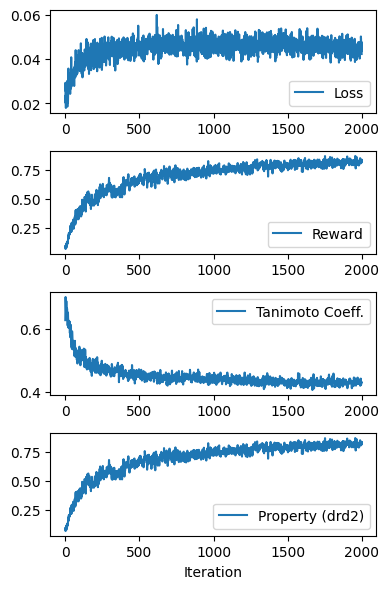

In [17]:
fig, axes = plt.subplots(4,1,figsize=(4,6))

axes[0].plot(df_history.loc[:,"LOSS"], label="Loss")
axes[1].plot(df_history.loc[:,"REWARD"], label="Reward")
axes[2].plot(df_history.loc[:,"SIMILARITY"], label="Tanimoto Coeff.")
axes[3].plot(df_history.loc[:,"PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

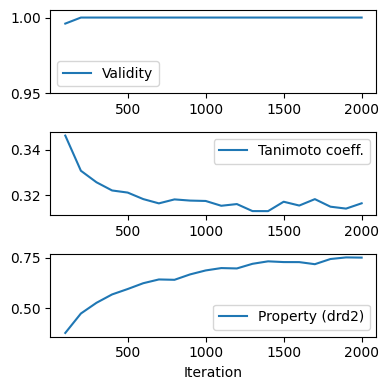

In [18]:
fig, axes = plt.subplots(3,1,figsize=(4,4))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")
axes[2].plot(df_history_valid.loc[:,"AVERAGE_PROPERTY"], label=f"Property ({PROPERTY_NAME})")

axes[0].set_ylim(0.95, 1.005)

axes[2].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()